In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import OneHotEncoder
import datetime as dt

In [2]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils import to_categorical
import keras 

In [3]:
def add_date_data(DF):
    DF_dates=pd.DataFrame({'date':DF.date.unique(),'year':0,'year_week':0,
                          'month':0,'month_day':0,
                          'year_day':0,'weekday':0,
                          'week':0})

    for ind in DF_dates.index:
        date=DF_dates.date[ind]
        date_st=date.timetuple()
        DF_dates.loc[ind,'year']=date_st.tm_year
        DF_dates.loc[ind,'month']=date_st.tm_mon
        DF_dates.loc[ind,'month_day']=date_st.tm_mday
        DF_dates.loc[ind,'year_day']=date_st.tm_yday
        DF_dates.loc[ind,'weekday']=date_st.tm_wday
        DF_dates.loc[ind,'year_week']=date.isocalendar()[0]
        DF_dates.loc[ind,'week']=date.isocalendar()[1]
        
        
    DF=DF.merge(DF_dates, on='date')
    return DF

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([0, len(loss)+5, 0, 1.1*max(max(loss),max(val_loss))])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# Import Data.
## Energy Generated

In [4]:
Energy=pd.read_csv('../../Data/subsystem_all_dams/Energy_generated_daily_by_dam.csv.zip')
Energy=Energy.groupby('date').sum('energy_generated').reset_index()
Energy['date']=pd.to_datetime(Energy.date)

## Demand (whole subsystem) and Influent Flow per dam. 

In [5]:
DF=pd.read_csv('../../Data/subsystem_all_dams/Selected_important_dams_energy_demand_flow.csv.zip')
DF=DF[['date', 'influent_flow', 'energy_generated', 'maximum_demand','dam']]
DF['date']=pd.to_datetime(DF.date)

In [6]:
Demand=DF[['date','maximum_demand']].groupby('date').max().reset_index()

Flows=DF[['date','dam','influent_flow']].pivot(index='date', columns='dam', values='influent_flow')#.reset_index()
Flows.columns=['Flow_'+x.lower().replace(' ','_') for x in Flows.columns]
Flows=Flows.reset_index()
Flows['date']=pd.to_datetime(Flows.date)

In [7]:
#Combine all:
Dates=pd.DataFrame({'date':pd.date_range(start='2000-01-01', end='2020-12-31')})
Complete_DF=Dates.merge(Energy, how='left', on='date').\
                    merge(Demand, how='left', on='date').\
                    merge(Flows,how='left', on='date')
Complete_DF=Complete_DF.sort_values('date')
Complete_DF=add_date_data(Complete_DF)

In [8]:
agg_dict={flow:'mean' for flow in Flows.columns if 'Flow' in flow}
agg_dict['date']='max'; agg_dict['month']=pd.Series.mode
agg_dict['energy_generated']='sum'; agg_dict['maximum_demand']='sum'
Complete_DF=Complete_DF.groupby(['year_week','week']).agg(agg_dict).reset_index()

In [9]:
Month=pd.DataFrame(OneHotEncoder(sparse=False).fit_transform(Complete_DF[['month']]))
Complete_DF=pd.concat([Complete_DF.drop(['month', 'year_week', 'week'], axis=1),Month],axis=1)

## Rain data by state 

In [10]:
Rain1=pd.read_csv('../../Data/weekly_rain_by_state_data.csv',index_col=0)
Rain1['date']=pd.to_datetime(Rain1.date)

Rain1=Rain1.set_index('date').shift().reset_index()

In [11]:
Complete_DF=Complete_DF.merge(Rain1, on='date', how='left')
Complete_DF=Complete_DF[Complete_DF.date<='2020-12-27']#Take away the last week since it is not complete. 

## Rescale the data

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler_energy=StandardScaler()
scaler_demand=StandardScaler()
scaler_flow=StandardScaler()
scaler_rain=MinMaxScaler()

Scaled_DF=pd.DataFrame()
Scaled_DF['date']=Complete_DF['date']
Scaled_DF[list(range(12))]=Complete_DF[list(range(12))]
Scaled_DF[['energy_generated']]=\
        scaler_energy.fit_transform(Complete_DF[['energy_generated']])
Scaled_DF[['maximum_demand']]=\
        scaler_demand.fit_transform(Complete_DF[['maximum_demand']])
Scaled_DF[[name for name in Flows.columns if name!='date']]=\
        scaler_flow.fit_transform(Complete_DF[[name for name in Flows.columns if name!='date']])
Scaled_DF[[name for name in Rain1.columns if name!='date']]=\
        scaler_rain.fit_transform(Complete_DF[[name for name in Rain1.columns if name!='date']])

# Try a Regular Neural Net

## Using only Demand and Influent Flow

In [14]:
date_train='2017-01-01'
date_validate='2018-06-01'
date_test='2020-12-31'

DF=Scaled_DF.copy()
DF=DF.drop([name for name in DF.columns if 'rain' in str(name)],axis=1)
DF=DF.dropna(thresh=DF.shape[1]-3).fillna(0)

DF_train=DF[DF.date<=date_train]
X_train=np.array(DF_train.drop(['date','energy_generated'],axis=1))
y_train=np.array(DF_train['energy_generated'])

DF_validate=DF[(DF.date>date_train) & (DF.date<=date_validate)]
X_validate=np.array(DF_validate.drop(['date','energy_generated'],axis=1))
y_validate=np.array(DF_validate['energy_generated'])

DF_test=DF[(DF.date>date_validate) & (DF.date<=date_test)]
X_test=np.array(DF_test.drop(['date','energy_generated'],axis=1))
y_test=np.array(DF_test['energy_generated'])

In [15]:
model = models.Sequential()
model.add(layers.Dense(50,input_shape=[X_train.shape[1]]))
model.add(layers.Dense(50))
model.add(layers.Dense(50))
model.add(layers.Dense(1))
#model.summary()
model.compile(optimizer='rmsprop',loss='mae', metrics=['mae'])

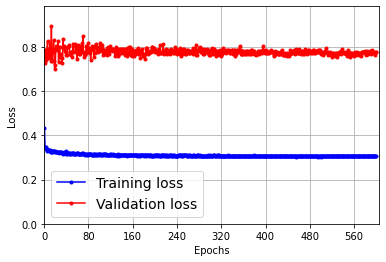

In [16]:
history = model.fit(X_train,y_train,epochs = 600,validation_data=(X_validate,y_validate), verbose=0)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

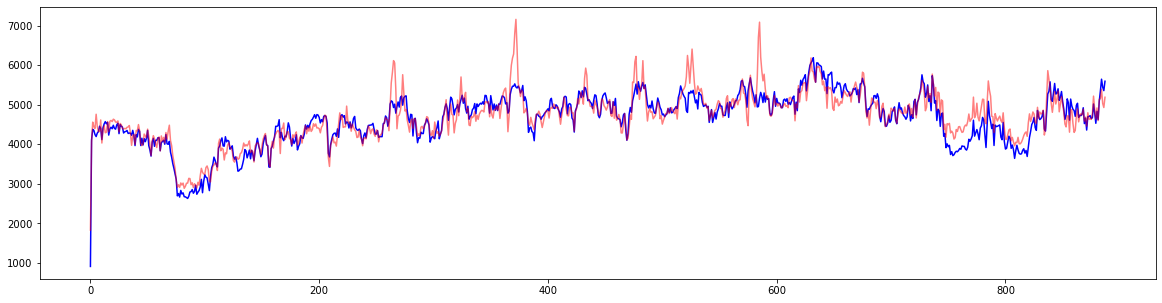

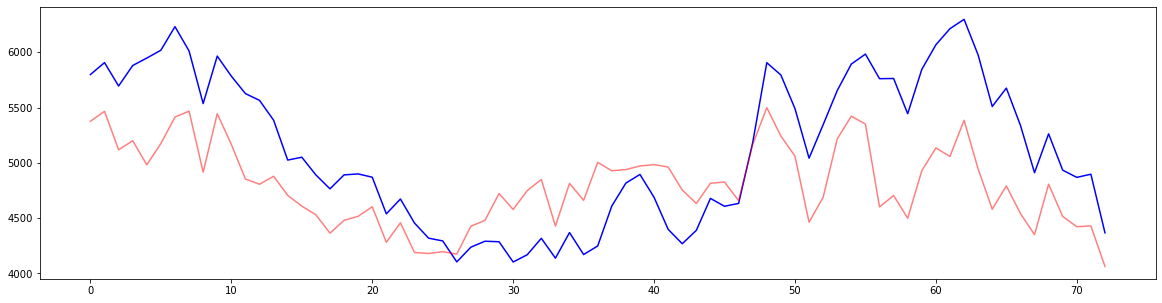

Validate error:  12.764219438264474 %


In [17]:
#Train Data
y_pred=model.predict(X_train)

y_pred0=scaler_energy.inverse_transform(y_pred)
y_train0=scaler_energy.inverse_transform(y_train)

plt.figure(figsize=(20,5))
plt.plot(y_train0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

#Validate Data
y_pred=model.predict(X_validate)

y_pred0=scaler_energy.inverse_transform(y_pred)
y_validate0=scaler_energy.inverse_transform(y_validate)


plt.figure(figsize=(20,5))
plt.plot(y_validate0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

print('Validate error: ',np.mean(np.abs(y_pred0-y_validate0)/y_validate0)*100,'%')

## Using only Demand and Rain

In [18]:
date_train='2017-01-01'
date_validate='2018-06-01'
date_test='2020-12-31'

DF=Scaled_DF.copy()
DF=DF.drop([name for name in DF.columns if 'Flow' in str(name)],axis=1).fillna(0)
DF=DF.dropna(thresh=DF.shape[1]-2).fillna(0)

DF_train=DF[DF.date<=date_train]
X_train=np.array(DF_train.drop(['date','energy_generated'],axis=1))
y_train=np.array(DF_train['energy_generated'])

DF_validate=DF[(DF.date>date_train) & (DF.date<=date_validate)]
X_validate=np.array(DF_validate.drop(['date','energy_generated'],axis=1))
y_validate=np.array(DF_validate['energy_generated'])

DF_test=DF[(DF.date>date_validate) & (DF.date<=date_test)]
X_test=np.array(DF_test.drop(['date','energy_generated'],axis=1))
y_test=np.array(DF_test['energy_generated'])

In [19]:
model = models.Sequential()
model.add(layers.Dense(50,input_shape=[X_train.shape[1]]))
model.add(layers.Dense(50))
model.add(layers.Dense(50))
model.add(layers.Dense(1))
#model.summary()
model.compile(optimizer='rmsprop',loss='mae', metrics=['mae'])

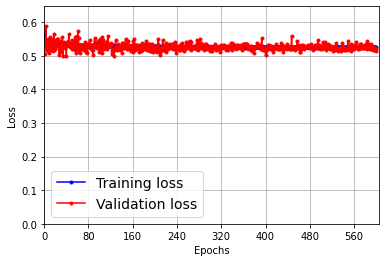

In [20]:
history = model.fit(X_train,y_train,epochs = 600,validation_data=(X_validate,y_validate), verbose=0)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

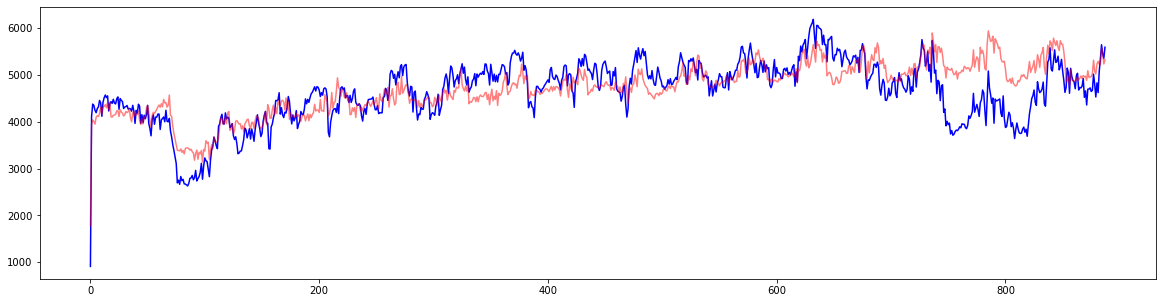

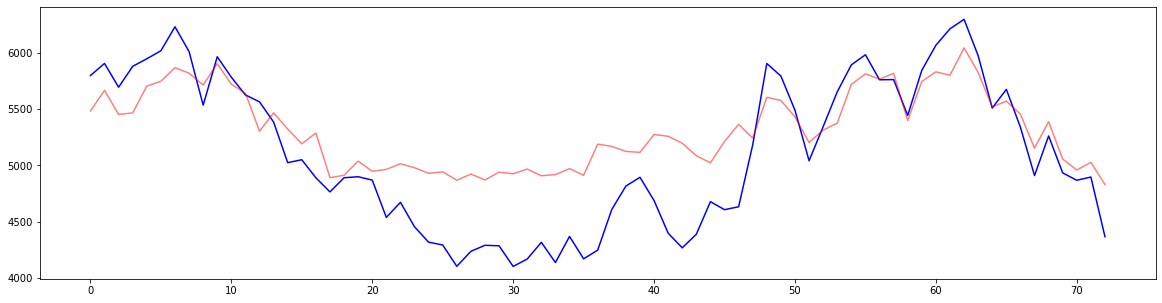

Validate error:  13.233475241078391 %


In [21]:
#Train Data
y_pred=model.predict(X_train)

y_pred0=scaler_energy.inverse_transform(y_pred)
y_train0=scaler_energy.inverse_transform(y_train)

plt.figure(figsize=(20,5))
plt.plot(y_train0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

#Validate Data
y_pred=model.predict(X_validate)

y_pred0=scaler_energy.inverse_transform(y_pred)
y_validate0=scaler_energy.inverse_transform(y_validate)


plt.figure(figsize=(20,5))
plt.plot(y_validate0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

print('Validate error: ',np.mean(np.abs(y_pred0-y_validate0)/y_validate0)*100,'%')

## Using only Rain and Month

In [22]:
date_train='2017-01-01'
date_validate='2018-06-01'
date_test='2020-12-31'

DF=Scaled_DF.copy()
DF=DF.drop([name for name in DF.columns if 'Flow' in str(name)],axis=1)
DF=DF.drop(['maximum_demand'],axis=1)
DF=DF.dropna(thresh=DF.shape[1]-2).fillna(0)

DF_train=DF[DF.date<=date_train]
X_train=np.array(DF_train.drop(['date','energy_generated'],axis=1))
y_train=np.array(DF_train['energy_generated'])

DF_validate=DF[(DF.date>date_train) & (DF.date<=date_validate)]
X_validate=np.array(DF_validate.drop(['date','energy_generated'],axis=1))
y_validate=np.array(DF_validate['energy_generated'])

DF_test=DF[(DF.date>date_validate) & (DF.date<=date_test)]
X_test=np.array(DF_test.drop(['date','energy_generated'],axis=1))
y_test=np.array(DF_test['energy_generated'])

In [23]:
model = models.Sequential()
model.add(layers.Dense(50,input_shape=[X_train.shape[1]]))
model.add(layers.Dense(50))
model.add(layers.Dense(50))
model.add(layers.Dense(1))
#model.summary()
model.compile(optimizer='rmsprop',loss='mae', metrics=['mae'])

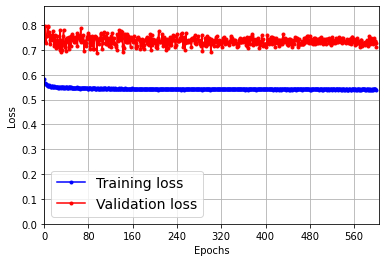

In [24]:
history = model.fit(X_train,y_train,epochs = 600,validation_data=(X_validate,y_validate), verbose=0)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

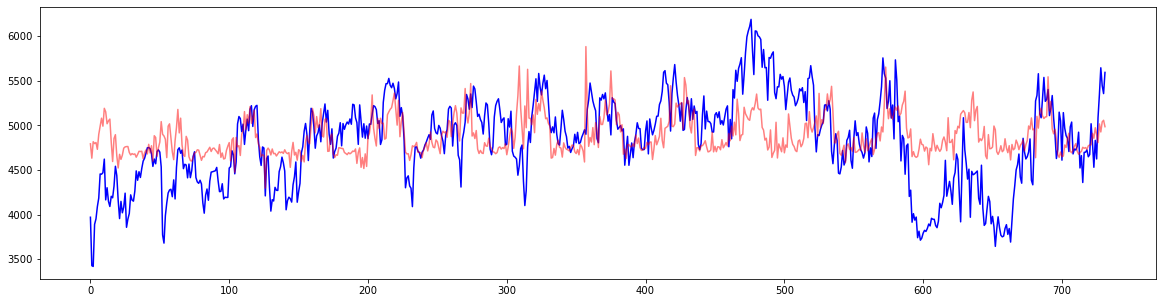

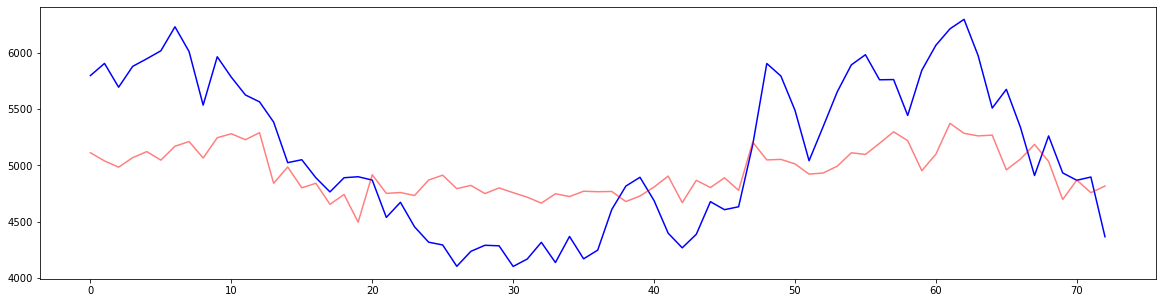

Validate error:  11.74332275861374 %


In [25]:
#Train Data
y_pred=model.predict(X_train)

y_pred0=scaler_energy.inverse_transform(y_pred)
y_train0=scaler_energy.inverse_transform(y_train)

plt.figure(figsize=(20,5))
plt.plot(y_train0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

#Validate Data
y_pred=model.predict(X_validate)

y_pred0=scaler_energy.inverse_transform(y_pred)
y_validate0=scaler_energy.inverse_transform(y_validate)


plt.figure(figsize=(20,5))
plt.plot(y_validate0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

print('Validate error: ',np.mean(np.abs(y_pred0-y_validate0)/y_validate0)*100,'%')

# Prepare for a LSTM Neural Net.
We separate the data in training, validating and test sets. 
Then separate the data into chunks to predict. 

In [59]:
def separate_chunks(X, y, length=12, n_future=1):
    Xs=np.array([X[k:length+k,:] for k in range(X.shape[0]-length+1-n_future)])
    ys=np.array([[y[length+k+n_future-1]] for k in range(X.shape[0]-length-n_future+1)])
    return Xs, ys

In [60]:
date_train='2017-01-01'
date_validate='2018-06-01'
date_test='2020-12-31'
n_future=4

DF=Scaled_DF.copy()
#Drop the Month columns
DF=DF.drop(list(range(12)),axis=1)
DF=DF.dropna(thresh=DF.shape[1]-3).fillna(0)
DF=DF.sort_values('date')

DF_train=DF[DF.date<=date_train]
X_train=np.array(DF_train.drop(['date'],axis=1))
y_train=np.array(DF_train['energy_generated'])
X_train, y_train=separate_chunks(X_train,y_train,n_future=n_future)

DF_validate=DF[(DF.date>date_train) & (DF.date<=date_validate)]
X_validate=np.array(DF_validate.drop(['date'],axis=1))
y_validate=np.array(DF_validate['energy_generated'])
X_validate, y_validate=separate_chunks(X_validate,y_validate,n_future=n_future)

DF_test=DF[(DF.date>date_validate) & (DF.date<=date_test)]
X_test=np.array(DF_test.drop(['date'],axis=1))
y_test=np.array(DF_test['energy_generated'])
X_test,y_test=separate_chunks(X_test,y_test,n_future=n_future)

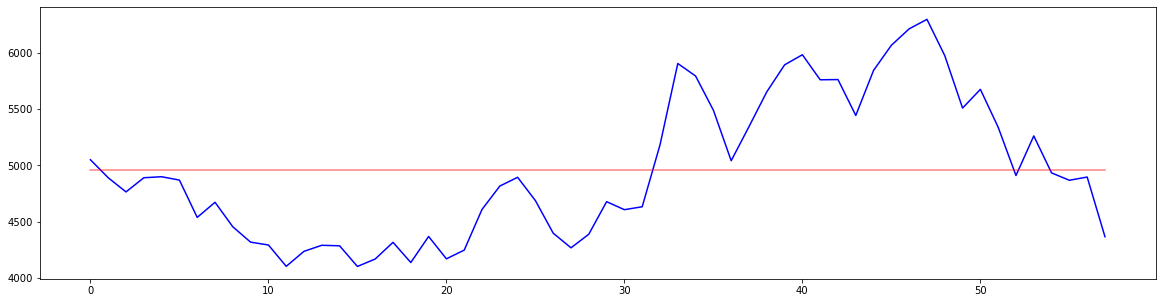

Just the mean:  10.717887047035486 %


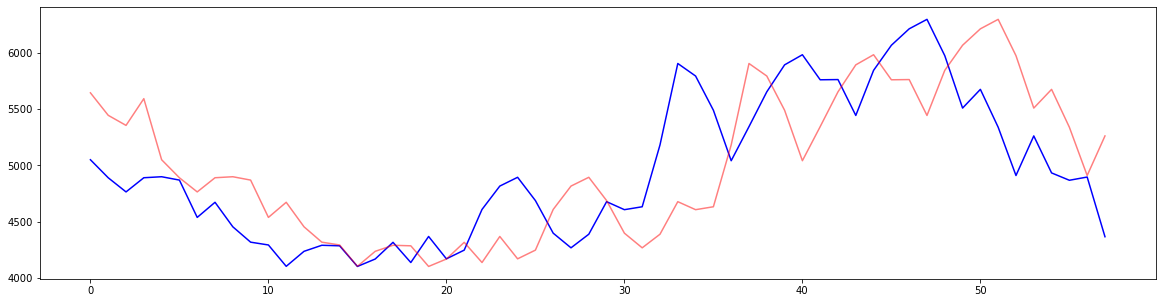

Use past known value:  8.242759913576561 %


In [75]:
y_validate0=scaler_energy.inverse_transform(y_validate)
y_pred0=np.array([np.mean(y_validate0)]*len(y_validate0))

plt.figure(figsize=(20,5))
plt.plot(y_validate0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()
print('Just the mean: ',np.mean(np.abs(y_pred0-y_validate0)/y_validate0)*100,'%')

y_pred=np.array(list(y_train[-n_future:])+list(y_validate[0:-n_future]))
y_pred0=scaler_energy.inverse_transform(y_pred)

plt.figure(figsize=(20,5))
plt.plot(y_validate0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

print('Use past known value: ',np.mean(np.abs(y_pred0-y_validate0)/y_validate0)*100,'%')

In [62]:
model = models.Sequential()
model.add(layers.LSTM(5,input_shape=[None,X_train.shape[2]],return_sequences=True))
model.add(layers.LSTM(5,return_sequences=True))
model.add(layers.Dense(1))
#model.summary()
model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])

In [63]:
history = model.fit(X_train,y_train,epochs = 100, validation_data=(X_validate,y_validate),verbose=0)

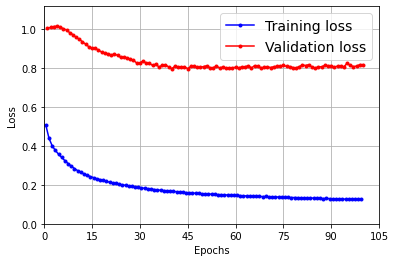

In [64]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

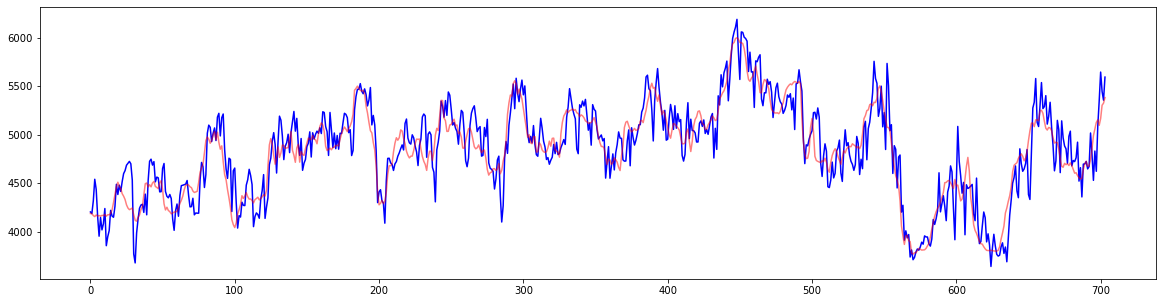

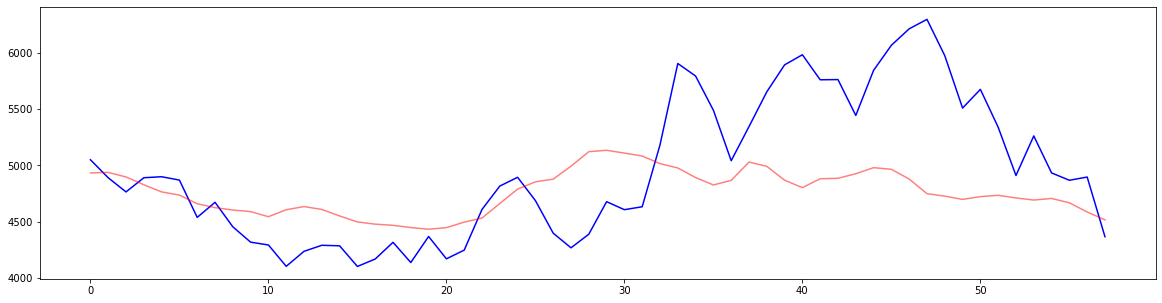

Validate error:  8.889134521586826 %


In [65]:
#Train Data
y_pred=model.predict(X_train)

y_pred0=scaler_energy.inverse_transform(y_pred[:,-1,:])
y_train0=scaler_energy.inverse_transform(y_train)

plt.figure(figsize=(20,5))
plt.plot(y_train0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

#Validate Data
y_pred=model.predict(X_validate)

y_pred0=scaler_energy.inverse_transform(y_pred[:,-1,:])
y_validate0=scaler_energy.inverse_transform(y_validate)


plt.figure(figsize=(20,5))
plt.plot(y_validate0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

print('Validate error: ',np.mean(np.abs(y_pred0-y_validate0)/y_validate0)*100,'%')

## Use just: Rain and previous months of energy_generated

In [33]:
date_train='2017-01-01'
date_validate='2018-06-01'
date_test='2020-12-31'
n_future=4

DF=Scaled_DF.copy()
#Just keep few columns
DF=DF[['energy_generated']+list(Rain1.columns)]
DF=DF[DF.date>=Rain1.date.min()]
DF=DF.fillna(0)
DF=DF.sort_values('date')

DF_train=DF[DF.date<=date_train]
X_train=np.array(DF_train.drop(['date'],axis=1))
y_train=np.array(DF_train['energy_generated'])
X_train, y_train=separate_chunks(X_train,y_train,n_future=n_future)

DF_validate=DF[(DF.date>date_train) & (DF.date<=date_validate)]
X_validate=np.array(DF_validate.drop(['date'],axis=1))
y_validate=np.array(DF_validate['energy_generated'])
X_validate, y_validate=separate_chunks(X_validate,y_validate,n_future=n_future)

DF_test=DF[(DF.date>date_validate) & (DF.date<=date_test)]
X_test=np.array(DF_test.drop(['date'],axis=1))
y_test=np.array(DF_test['energy_generated'])
X_test,y_test=separate_chunks(X_test,y_test,n_future=n_future)

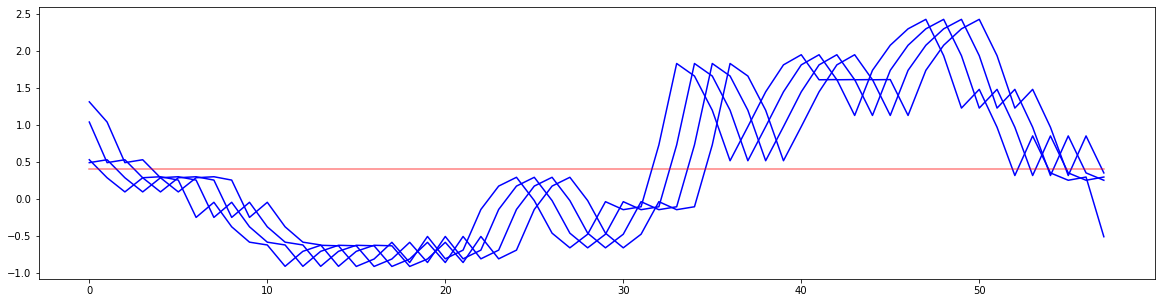

ValueError: operands could not be broadcast together with shapes (58,) (58,4) 

In [57]:
y_pred=[np.mean(y_validate)]*y_validate.shape[0]
plt.figure(figsize=(20,5))
plt.plot(y_validate,color='blue')
plt.plot(y_pred,color='red',alpha=0.5)
plt.show()
print('Just the mean: ', np.mean(np.abs((y_pred-y_validate))))

y_pred=np.array(list(y_train[-n_future:])+list(y_validate[0:-n_future]))

y_pred0=scaler_energy.inverse_transform(y_pred)
y_validate0=scaler_energy.inverse_transform(y_validate)

plt.figure(figsize=(20,5))
plt.plot(y_validate0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

print('Validate error: ',np.mean(np.abs(y_pred0-y_validate0)/y_validate0)*100,'%')

In [35]:
model = models.Sequential()
model.add(layers.LSTM(5,input_shape=[None,X_train.shape[2]],return_sequences=True))
model.add(layers.LSTM(5,return_sequences=True))
model.add(layers.Dense(1))
#model.summary()
model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])

In [36]:
history = model.fit(X_train,y_train,epochs = 100, validation_data=(X_validate,y_validate),verbose=0)

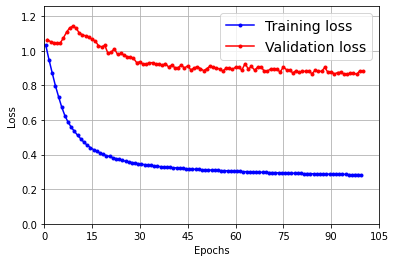

In [37]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

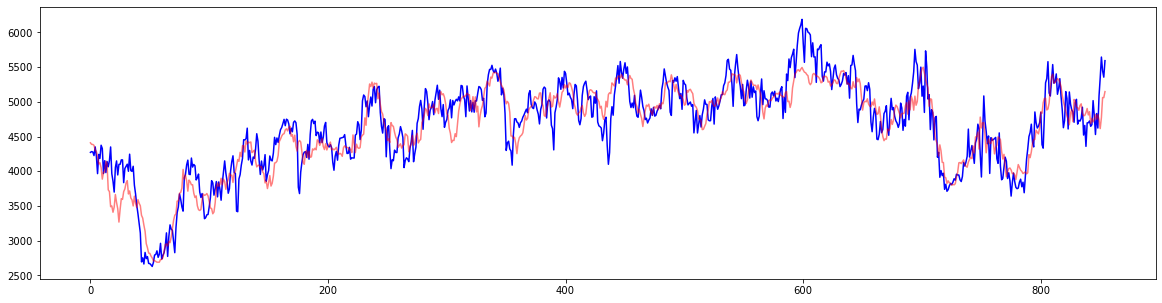

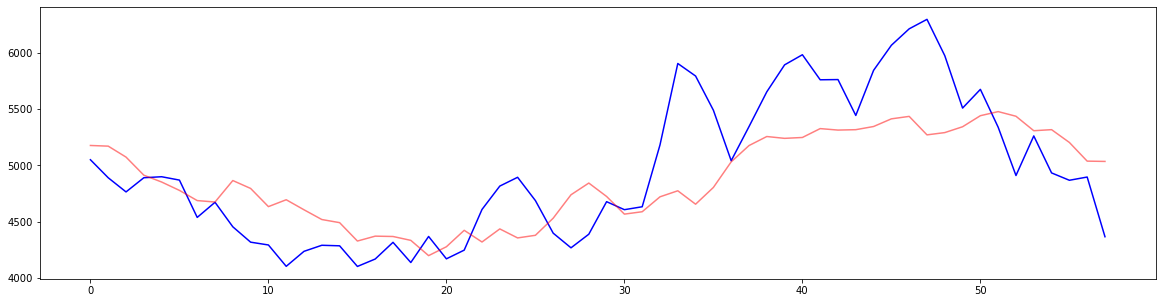

Validate error:  6.793425098399003 %


In [38]:
#Train Data
y_pred=model.predict(X_train)

y_pred0=scaler_energy.inverse_transform(y_pred[:,-1,:])
y_train0=scaler_energy.inverse_transform(y_train)

plt.figure(figsize=(20,5))
plt.plot(y_train0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

#Validate Data
y_pred=model.predict(X_validate)

y_pred0=scaler_energy.inverse_transform(y_pred[:,-1,:])
y_validate0=scaler_energy.inverse_transform(y_validate)


plt.figure(figsize=(20,5))
plt.plot(y_validate0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

print('Validate error: ',np.mean(np.abs(y_pred0-y_validate0)/y_validate0)*100,'%')

## Use just: Previous months and Rain and demand

In [117]:
date_train='2017-01-01'
date_validate='2018-06-01'
date_test='2020-12-31'
n_future=4
length=36

DF=Scaled_DF.copy()
#Just keep few columns
DF=DF[['energy_generated', 'maximum_demand']+list(Rain1.columns)]
DF=DF[DF.date>=Rain1.date.min()]
DF=DF.fillna(0)
DF=DF.sort_values('date')

DF_train=DF[DF.date<=date_train]
X_train=np.array(DF_train.drop(['date'],axis=1))
y_train=np.array(DF_train['energy_generated'])
X_train, y_train=separate_chunks(X_train,y_train,n_future=n_future,length=length)

DF_validate=DF[(DF.date>date_train) & (DF.date<=date_validate)]
X_validate=np.array(DF_validate.drop(['date'],axis=1))
y_validate=np.array(DF_validate['energy_generated'])
X_validate, y_validate=separate_chunks(X_validate,y_validate,n_future=n_future,length=length)

DF_test=DF[(DF.date>date_validate) & (DF.date<=date_test)]
X_test=np.array(DF_test.drop(['date'],axis=1))
y_test=np.array(DF_test['energy_generated'])
X_test,y_test=separate_chunks(X_test,y_test,n_future=n_future,length=length)

In [118]:
model = models.Sequential()
model.add(layers.LSTM(1,input_shape=[None,X_train.shape[2]],return_sequences=True))
model.add(layers.LSTM(1,return_sequences=True))
model.add(layers.Dense(1))
#model.summary()
model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])

In [119]:
history = model.fit(X_train,y_train,epochs = 200, validation_data=(X_validate,y_validate),verbose=0)

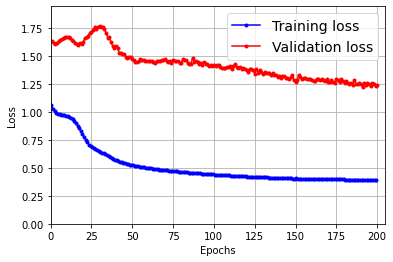

In [120]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

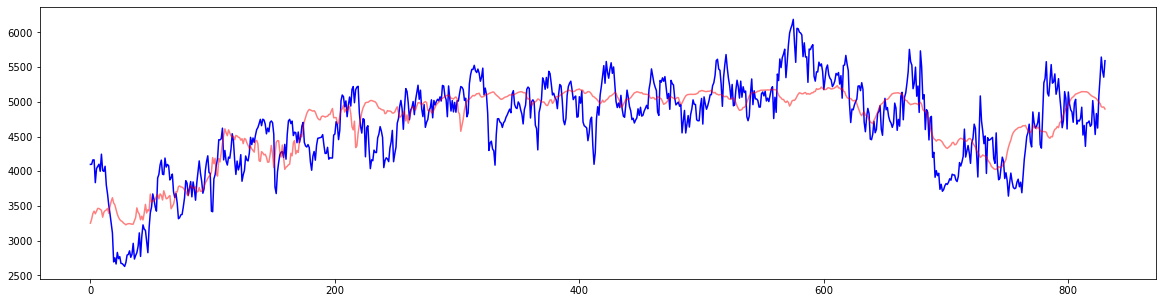

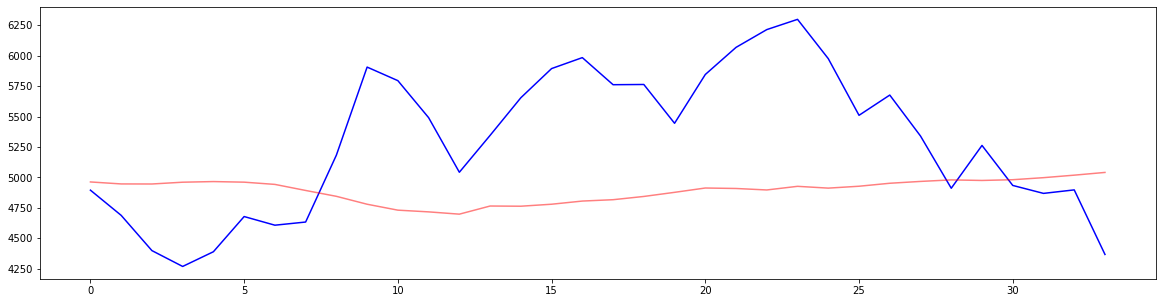

Validate error:  11.613980861583444 %


In [121]:
#Train Data
y_pred=model.predict(X_train)

y_pred0=scaler_energy.inverse_transform(y_pred[:,-1,:])
y_train0=scaler_energy.inverse_transform(y_train)

plt.figure(figsize=(20,5))
plt.plot(y_train0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

#Validate Data
y_pred=model.predict(X_validate)

y_pred0=scaler_energy.inverse_transform(y_pred[:,-1,:])
y_validate0=scaler_energy.inverse_transform(y_validate)


plt.figure(figsize=(20,5))
plt.plot(y_validate0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

print('Validate error: ',np.mean(np.abs(y_pred0-y_validate0)/y_validate0)*100,'%')

## Forecast 4 weeks (at the same time).
Use only Rain data and previous energy_generated, and demand

In [122]:
def separate_chunks2(X, y, length=12, n_future=1):
    Xs=np.array([X[k:length+k,:] for k in range(X.shape[0]-length+1-n_future)])
    ys=np.array([np.array(y[(length+k):(length+k+n_future)]) for k in range(X.shape[0]-length-n_future+1)])
    return Xs, ys

In [181]:
date_train='2017-01-01'
date_validate='2018-06-01'
date_test='2020-12-31'
n_future=12
length=36

DF=Scaled_DF.copy()
#Just keep few columns
DF=DF[['energy_generated','maximum_demand']+list(Rain1.columns)]
DF=DF[DF.date>=Rain1.date.min()]
DF=DF.fillna(0)
DF=DF.sort_values('date')

DF_train=DF[DF.date<=date_train]
X_train=np.array(DF_train.drop(['date'],axis=1))
y_train=np.array(DF_train['energy_generated'])
X_train, y_train=separate_chunks2(X_train,y_train,n_future=n_future,length=length)

DF_validate=DF[(DF.date>date_train) & (DF.date<=date_validate)]
X_validate=np.array(DF_validate.drop(['date'],axis=1))
y_validate=np.array(DF_validate['energy_generated'])
X_validate, y_validate=separate_chunks2(X_validate,y_validate,n_future=n_future,length=length)

DF_test=DF[(DF.date>date_validate) & (DF.date<=date_test)]
X_test=np.array(DF_test.drop(['date'],axis=1))
y_test=np.array(DF_test['energy_generated'])
X_test,y_test=separate_chunks2(X_test,y_test,n_future=n_future,length=length)

In [192]:
model = models.Sequential()
model.add(layers.LSTM(5,input_shape=[None,X_train.shape[2]],return_sequences=True))
model.add(layers.LSTM(5,return_sequences=True))
model.add(layers.LSTM(5))
model.add(layers.Dense(n_future))
#model.summary()

In [193]:
model.compile(optimizer='adam',loss='mse', metrics=['mae'])#optimizer='rmsprop'

In [194]:
history = model.fit(X_train,y_train,epochs = 15, validation_data=(X_validate,y_validate), verbose=2)

Epoch 1/15
26/26 - 4s - loss: 0.9812 - mae: 0.7644 - val_loss: 1.9626 - val_mae: 1.2028
Epoch 2/15
26/26 - 1s - loss: 0.9531 - mae: 0.7528 - val_loss: 1.9722 - val_mae: 1.2036
Epoch 3/15
26/26 - 1s - loss: 0.9111 - mae: 0.7336 - val_loss: 1.9949 - val_mae: 1.2075
Epoch 4/15
26/26 - 1s - loss: 0.8511 - mae: 0.7039 - val_loss: 2.0257 - val_mae: 1.2148
Epoch 5/15
26/26 - 1s - loss: 0.7836 - mae: 0.6692 - val_loss: 2.0396 - val_mae: 1.2189
Epoch 6/15
26/26 - 1s - loss: 0.7096 - mae: 0.6324 - val_loss: 1.9878 - val_mae: 1.2049
Epoch 7/15
26/26 - 1s - loss: 0.6354 - mae: 0.5969 - val_loss: 2.2591 - val_mae: 1.2929
Epoch 8/15
26/26 - 1s - loss: 0.5636 - mae: 0.5616 - val_loss: 2.0441 - val_mae: 1.2335
Epoch 9/15
26/26 - 1s - loss: 0.4982 - mae: 0.5285 - val_loss: 1.7279 - val_mae: 1.1340
Epoch 10/15
26/26 - 1s - loss: 0.4469 - mae: 0.5028 - val_loss: 1.5181 - val_mae: 1.0531
Epoch 11/15
26/26 - 1s - loss: 0.4054 - mae: 0.4795 - val_loss: 1.3980 - val_mae: 1.0068
Epoch 12/15
26/26 - 1s - loss:

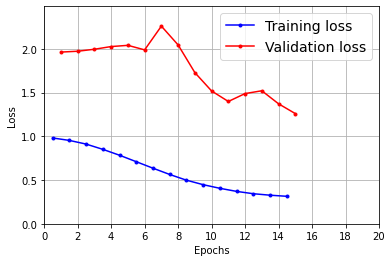

In [195]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

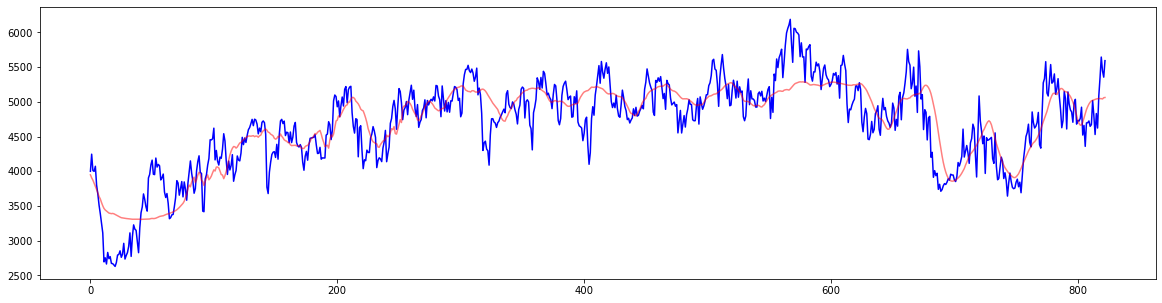

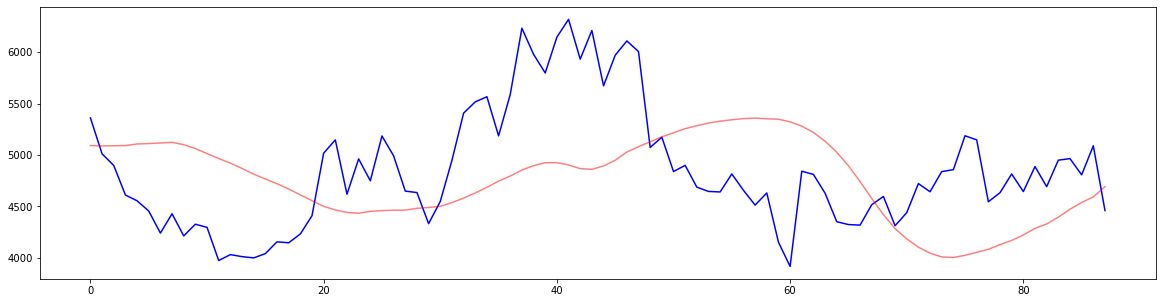

Validate error:  12.679538892740672 %


In [191]:
weeks_ahead=n_future

#Train Data
y_pred=model.predict(X_train)
y_train0=y_train[:,weeks_ahead-1]
y_pred0=y_pred[:,weeks_ahead-1]

y_pred0=scaler_energy.inverse_transform(y_pred0)
y_train0=scaler_energy.inverse_transform(y_train0)

plt.figure(figsize=(20,5))
plt.plot(y_train0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

#Validate Data
y_pred=model.predict(X_test)
y_validate0=y_test[:,weeks_ahead-1]
y_pred0=y_pred[:,weeks_ahead-1]

y_pred0=scaler_energy.inverse_transform(y_pred0)
y_validate0=scaler_energy.inverse_transform(y_validate0)

plt.figure(figsize=(20,5))
plt.plot(y_validate0,color='blue')
plt.plot(y_pred0,color='red',alpha=0.5)
plt.show()

print('Validate error: ',np.mean(np.abs(y_pred0-y_validate0)/y_validate0)*100,'%')